In [105]:
import numpy as np
from datetime import datetime, timedelta
import pandas as pd

Define the functions for Baum-Welch that we will use

In [ ]:

from scipy.stats import multivariate_normal
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

def forward(loga, logb, T, M, logpi):
    logalpha = np.empty((T, M))
    for i in range(M):
        logalpha[0, i] = logpi[i] + logb[0, i]
    for t in range(1, T):
        for j in range(M):
            logterms = [loga[i, j] + logalpha[t - 1, i] for i in range(M)]
            logalpha[t, j] = np.logaddexp.reduce(logterms) + logb[t, j]
        
    return logalpha

def backward(loga, logb, T, M):
    logbeta = np.empty((T, M))
    logbeta[T - 1, :] = 0
    for t in range(T - 2, -1, -1):
        for i in range(M):
            logterms = [loga[i, j] + logb[t + 1, i] + logbeta[t + 1, j] for j in range(M)]
            logbeta[t, i] = np.logaddexp.reduce(logterms)
            
    return logbeta

def compute_gamma(logalpha, logbeta, T, M):
    loggamma = np.empty((T, M))
    for t in range(T):
        for i in range(M):
            loggamma[t, i] = logalpha[t, i] + logbeta[t, i] - np.logaddexp.reduce([
                logalpha[t, j] + logbeta[t, j] for j in range(M)
            ])

    return loggamma

def compute_xi(logalpha, logbeta, loga, logb, T, M):
    xi = np.empty((T, M, M))
    for t in range(T - 1):
        for i in range(M):
            for j in range(M):
                logterms = []
                for k in range(M):
                    for l in range(M):
                        logterms.append(
                            logalpha[t, k] + loga[k, l] + logb[t + 1, l] + logbeta[t + 1, l]
                        )
                xi[t, i, j] = (
                    logalpha[t, i] + loga[i, j] + logb[t + 1, j] + logbeta[t + 1, j]
                    - np.logaddexp.reduce(logterms)
                )
    return xi

def compute_a(loggamma, logxi, T, M):
    loga = np.empty((M, M))
    for i in range(M):
        for j in range(M):
            loga[i, j] = (
                np.logaddexp.reduce([logxi[t, i, j] for t in range(T - 1)])
                - np.logaddexp.reduce([loggamma[t, i] for t in range(T - 1)])
            )
    return loga

def compute_b(mus, Sigmas, dataset, T, M):
    """
    mus: M x N mean returns (over time) per regime and asset
    Sigmas: M x N x N the covariance matrix per regime
    dataset: T x N matrix of returns

    returns: logB, T x M, where logB[t,k] = log p(r_t | s_t = k)
    """

    logb = np.empty((T, M))
    for t in range(T):
        for k in range(M):
            if np.isnan(dataset[t, :]).any() or np.isnan(mus[k, :]).any() or np.isnan(Sigmas[k, :, :]).any():
                raise AssertionError()
            logb[t, k] = multivariate_normal.logpdf(dataset[t, :], mus[k, :], Sigmas[k, :, :])
    return logb

def compute_mus_sigmas(loggamma, dataset, T, M, N, eps=1e-04):
    mus = np.empty((M, N))
    Sigmas = np.empty((M, N, N))
    for m in range(M):
        exp_gammas = np.empty(T)

        # compute mus
        exp_gammas = np.exp(loggamma[:, m])
        den = exp_gammas.sum()
        if den < eps:
            # state got no responsibility -> reinitialize it
            mus[m, :] = np.mean(dataset, axis=0) + np.random.normal(0, 0.01, size=N)
            Sigmas[m, :, :] = np.cov(dataset.T) + eps * np.eye(N)
            continue
        
        mus[m, :] = np.sum(exp_gammas[:, None] * dataset, axis=0) / den

        # compute Sigmas
        diffs = dataset - mus[m, :]
        Sigmas[m, :, :] = (diffs.T @ (diffs * exp_gammas[:, None])) / den

        # stabilize
        Sigmas[m, :, :] = (Sigmas[m, :, :] + Sigmas[m, :, :].T) / 2
        Sigmas[m, :, :] += eps * np.eye(N)

    return mus, Sigmas

def match_states_by_B(B_est, B_true):
    # cost = L2 distance between emission distributions (rows)
    cost = cdist(B_est, B_true, metric='euclidean')  # shape (N_est, N_true)
    row_ind, col_ind = linear_sum_assignment(cost)
    # row_ind[i] -> col_ind[i], we want a permutation array perm where perm[est_index] = true_index
    perm = np.empty(B_est.shape[0], dtype=int)
    perm[row_ind] = col_ind
    return perm

def permute_model(pi, A, mus, Sigmas, perm):
    M = len(perm)
    pi_r = np.zeros_like(pi)
    A_r = np.zeros_like(A)
    mus_r = np.zeros_like(mus)
    Sigmas_r = np.zeros_like(Sigmas)
    # perm[est_i] = true_i
    for est_i, true_i in enumerate(perm):
        pi_r[true_i] = pi[est_i]
    for est_i, true_i in enumerate(perm):
        for est_j, true_j in enumerate(perm):
            A_r[true_i, true_j] = A[est_i, est_j]
    for est_i, true_i in enumerate(perm):
        mus_r[true_i] = mus[est_i]
        Sigmas_r[true_i] = Sigmas[est_i]
    return pi_r, A_r, mus_r, Sigmas_r

def kl_gaussian(mu0, S0, mu1, S1, eps=1e-8):
    # KL(N0 || N1)
    d = mu0.shape[0]
    # regularize
    S0 = S0 + eps * np.eye(d)
    S1 = S1 + eps * np.eye(d)
    invS1 = np.linalg.inv(S1)
    diff = (mu1 - mu0).reshape(-1, 1)
    term_trace = np.trace(invS1 @ S0)
    term_quad = float(diff.T @ invS1 @ diff)
    # sign and natural log of determinant
    sign0, logdet0 = np.linalg.slogdet(S0)
    sign1, logdet1 = np.linalg.slogdet(S1)
    logdet_ratio = logdet1 - logdet0
    return 0.5 * (term_trace + term_quad - d + logdet_ratio)

def sym_kl(mu0, S0, mu1, S1, eps=1e-8):
    return kl_gaussian(mu0, S0, mu1, S1, eps) + kl_gaussian(mu1, S1, mu0, S0, eps)

def match_states_by_gaussians(mus_est, Sigmas_est, mus_true, Sigmas_true, eps=1e-8):
    M = mus_est.shape[0]
    cost = np.zeros((M, M))
    for i in range(M):
        for j in range(M):
            cost[i, j] = sym_kl(mus_est[i], Sigmas_est[i], mus_true[j], Sigmas_true[j], eps)
    row_ind, col_ind = linear_sum_assignment(cost)
    # build perm such that perm[est_i] = true_j
    perm = np.zeros(M, dtype=int)
    for r, c in zip(row_ind, col_ind):
        perm[r] = c
    return perm

def viterbi(logpi, logb, loga, T):
    logdelta = np.zeros((T, 4))
    psi = np.zeros((T, 4))
    # logdelta[t, j] = log probability of the best path ending in state j at time t
    # psi[t, j] = state that maximizes prob of having been there, over all seq
    # ended in j at time t
    logdelta[0, :] = logpi + logb[0, :]
    for t in range(1, T):
        for j in range(4):
            seq_probs = logdelta[t - 1, :] + loga[:, j]
            logdelta[t, j] = np.max(seq_probs) + logb[t, j]
            psi[t, j] = np.argmax(seq_probs)

    states = np.zeros(T, dtype=int) # holds most likely states for each time
    states[-1] = np.argmax(logdelta[-1, :])
    p = np.max(logdelta[-1, :]) # highest probability over all states (ended in T)

    for t in range(T - 2, -1, -1):
        states[t] = psi[t + 1, states[t + 1]]
        # S_{T-1}=argmax over all j of (logdelta[T - 1, j])

    return states, p

    

### Generating synthetic price and volatility data

We use the below functions (which are Heston stochastic processes) to generate synthetic trading data, to test the HMM.

https://en.wikipedia.org/wiki/Heston_model

In [106]:
def generate_volatility(V0=0.2, xi=0.15, theta=0.2, kappa=0.1, N=5000, dt=1/365):
    V = np.empty(N)
    V[0] = V0
    for i in range(1, N):
        dw_v = np.sqrt(dt) * np.random.normal()
        sigma = max(0, V[i-1] + kappa * (theta - V[i-1]) * dt + xi * np.sqrt(V[i-1]) * dw_v)
        V[i] = sigma
    return V

def generate_prices(vola_values, S0=100, mu=0.15, dt=1/365,
           volume=True, mu_volume=4, sigma_volume=1, N=5000):
    S = np.empty(N)
    S[0] = S0
    for i in range(1, N):
        dw_s = np.sqrt(dt) * np.random.normal()
        s = S[i-1] * np.exp((mu - 0.5 * vola_values[i]) * dt + np.sqrt(vola_values[i]) * dw_s)
        S[i] = s
    if volume:
        return S, np.random.lognormal(mu_volume, sigma_volume, len(S))
    return S


### K-means

We will use this algorithm to cluster asset volatility data, such that we can construct the initial parameters $A$, $\mu$, $\Sigma$ and $\pi$.

https://en.wikipedia.org/wiki/K-means_clustering

In [107]:
def k_means(data, k):
    # data: np-array of vectors (points), shape (n_vectors, vector_dim)
    # k: amount of clusters

    # data size: (n_points, vector_dim)

    center_indices = np.random.randint(0, len(data), size=(1,k)) # (1, k)
    centers = np.array([data[i] for i in center_indices]).reshape((k, data.shape[1])) # (k, vector_dim)
    
    clusters = [[] for _ in range(k)] # (k, n_vectors_to_cluster, vector_dim)
    
    while True:
        new_clusters = clusters
        """
        for every point: determine dist to every cluster
        categorize points based on dist (take smallest)
        redetermine clusters
        """

        labels = [] # length n_vectors

        # determine clusters
        for vector in data:
            # vector: (1, vector_dim)

            # distances for vector to every cluster vector
            # (1, k)

            distances = np.array([np.linalg.norm(vector - core) for core in centers])
            idx = np.argmin(distances)
            new_clusters[idx].append(vector) # list of length k
            labels.append(int(idx))

        if new_clusters == clusters:
            return clusters, centers, labels

        # determine new centers
        for k_idx, cluster in enumerate(clusters):
            # cluster: list of vectors
            avg_vector = np.zeros(data.shape[1])
            for vec in cluster:
                # vec: (vector_dim)
                avg_vector += vec
            avg_vector /= len(cluster)
            centers[k_idx,:] = avg_vector

In [ ]:
N = 5 # number of assets in portfolio
M = 3 # number of regimes (states)
T = 2000 # amount of timestamps
T_test = 1000 # n of timestamps used for evaluating/testing the model

# define A (transition prob. matrix)
A_real = np.array([
    [0.93, 0.07, 0.00],
    [0.02, 0.92, 0.06],
    [0.00, 0.10, 0.90]
])

regime = np.random.randint(0, M)
true_regimes_total = np.empty(T + T_test, dtype=int)
true_regimes_total[0] = regime
for t in range(1, T + T_test):
    next_regime = np.random.choice(list(range(M)), p=A_real[regime, :])
    true_regimes_total[t] = next_regime
    regime = next_regime

true_regimes = true_regimes_total[:T]
true_regimes_eval = true_regimes_total[T:]

pi_real = np.empty(M)
for m in range(M):
    print('amount of states', m, ':')
    pi_real[m] = np.count_nonzero(m == true_regimes)
    print(pi_real[m])

pi_real /= pi_real.sum()
print(pi_real)


amount of states 0 :
413.0
amount of states 1 :
1008.0
amount of states 2 :
579.0
[0.2065 0.504  0.2895]


In the below code we construct the array holding the true market regimes, derived from the true transition matrix $A$.

For each market regime $1,...,M$ we use a different parameter set $(\xi,\kappa,\theta,\mu)$ for the generation of price and volatility, and concatenate each sequence to obtain a length $T$ volatility and price sequence.

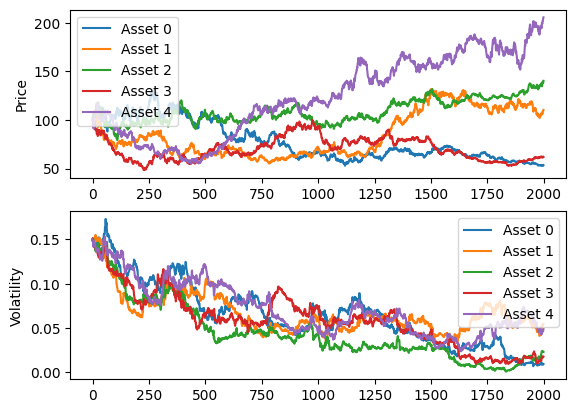

In [ ]:
xi_values = [0.05, 0.1, 0.2] # volatility of volatility
kappa_values = [1.5, 1.0, 0.5] # mean reversion rate
theta_values = [0.02, 0.04, 0.08] # mean volatility
mu_values = [0.07, 0.10, -0.02] # price drift

V0 = np.full(N, 0.15)
S0 = np.full(N, 100)

price_data_total = np.empty((T, N))
volatility_data_total = np.empty((T, N))

import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2)

t = 0
while t < T + T_test:
    this_regime = true_regimes[t]
    tt = t + 1
    while tt < T + T_test:
        if true_regimes[tt] == this_regime:
            tt += 1
        else:
            break
    volatility_data_total[t:tt, :] = np.array([
            generate_volatility(
                V0[i], xi_values[this_regime],
                theta_values[this_regime],
                kappa_values[this_regime],
                N=tt - t
            )
            for i in range(N)
        ]).T
    price_data_total[t:tt, :] = np.array([
        generate_prices(volatility_data_total[t:tt, i], S0[i], N=tt - t, volume=False, mu=mu_values[this_regime])
        for i in range(N)
    ]).T
    V0 = volatility_data_total[tt - 1, :]
    S0 = price_data_total[tt - 1, :]
    t = tt

price_data = price_data_total[:T]
price_data_eval = price_data_total[T:]
volatility_data = volatility_data_total[:T]
volatility_data_data_eval = volatility_data_total[T:]

for i in range(N):
    ax1.plot(range(T), price_data[:, i], label=f"Asset {i}")
    ax2.plot(range(T), volatility_data[:, i], label=f"Asset {i}")


ax1.legend()
ax2.legend()
ax1.set_ylabel("Price")
ax2.set_ylabel("Volatility")

plt.show()

Compute returns and cumulative returns per asset

In [ ]:
returns_total = pd.DataFrame(price_data_total).pct_change(axis=0)
returns_total.iloc[0] = np.zeros(N)
cum_returns_total = (returns_total + 1).cumprod() - 1
cum_returns = cum_returns_total[:T]
cum_returns_eval = cum_returns_total[T:]
returns = returns_total[:T]
returns_eval = returns_total[T:]

fig, ax = plt.subplots()
for i in range(N):
    ax.plot(range(T), cum_returns.values[:, i])

plt.show()

Construct true values of $\mu$, $\Sigma$ and $B$ parameters of the model, using return value and the true regime sequence

In [122]:
mus_real = np.empty((M, N))
Sigma_real = np.empty((M, N, N))

for m in range(M):
    reg_returns_real = returns.values[true_regimes == m, :]
    mus_real[m, :] = reg_returns_real.mean(axis=0)
    Sigma_real[m, :, :] = np.cov(reg_returns_real, rowvar=False)

# true value of B
logb_real = compute_b(mus_real, Sigma_real, returns.values, T, M)
B_real = np.exp(logb_real)

Compute the estimated volatility from the returns array and perform k-means on the volatility values, to obtain an estimated regime sequence.

We use this sequence to construct a parameter estimation set $(\mu_i,\Sigma_i)$ for each regime $i$.

In [ ]:
calc_volatility = returns.rolling(30, min_periods=0).std()
calc_volatility.iloc[0] = calc_volatility.iloc[1]
clusters, centers, est_regimes = k_means(calc_volatility.values, M)

est_regimes = np.array(est_regimes)

mus = np.empty((M, N))
mus_real = np.empty((M, N))

# mus: shape M x N
# clusters: shape M x (num_vectors_in_cluster) x N
Sigma = np.empty((M, N, N))
Sigma_real = np.empty((M, N, N))

for m in range(M):
    # find returns corresponding to regime m
    reg_returns = returns.values[est_regimes == m, :]
    
    mus[m, :] = reg_returns.mean(axis=0)
    cluster = np.array(clusters[m])
    Sigma[m, :, :] = np.cov(cluster, rowvar=False)
    

# construct the estimated version of A (using estimated regime sequence)
A = np.zeros((M, M))
pi = np.zeros(M)
for m in range(len(est_regimes[:-1])):
    cur_est_regime = est_regimes[m]
    next_est_regime = est_regimes[m + 1]
    A[cur_est_regime, next_est_regime] += 1
    pi[cur_est_regime] += 1
A_sum = A.sum(axis=1)
for n in range(M):
    A[n, :] /= A_sum[n]
pi /= pi.sum()

print(A)

[[0.95412844 0.00917431 0.03669725]
 [0.00968992 0.9127907  0.07751938]
 [0.01432665 0.0391595  0.94651385]]
[[-2.48291209e-04 -6.66476273e-04  9.32929270e-05 -1.28417970e-03
  -7.62126170e-04]
 [-1.18573584e-03  2.12249860e-04  2.63581795e-04  2.50610947e-04
   8.24617248e-04]
 [ 2.48991298e-04  4.25167529e-04  2.56648204e-04  9.86807508e-05
   7.68442679e-04]]


Run the algorithm

In [ ]:
pct_change_ll_tol = 0.01
n_attempts = 100
max_attempt_per_iter = 10

# noise addition to initial parameter guesses
A_noise_std = 0.2
pi_noise_std = 0.2
Sigma_noise_std = 0.2

# these will store data from every run
# structure: list of lists (inner list = data per iteration)
ll_list = []
diff_norms_A = []
diff_norms_B = []
diff_norms_pi = []

# these will store data from every run
# stucture: list of floats (one per attempt, not one per iteration)
pct_states_matched_viterbi = []
frac_correct_states_predicted_list = []
frac_correct_obs_predicted_list = []

for attempt in range(n_attempts):

    prev_ll = 1.0
    log_ll = 2.0

    # initialize parameters

    # choose diagonal values of A randomly
    A_est = np.empyt((M, M))
    for m in range(M):
        diagval = np.clip(A[m, m] + np.random.normal(0, A_noise_std), 0.01, 0.99)
        A_est[m, :] = (1 - diagval[m]) / (M - 1)
        A_est[m, m] = diagval[m]
    loga = np.log(A_est)

    mus_std = np.empty((M, N))
    mus_std_vals = mus.std(axis=1)
    for i in range(N):
        mus_std[:, i] = mus_std_vals

    mus_est = mus + np.random.normal(np.zeros((M, N)), mus_std, (M, N))
    
    E = np.random.normal(0, Sigma_noise_std, size=(M, N, N))
    Sigma_est = np.empty((M, N, N))
    for m in range(M):
        Sigma_est[m, :, :] = Sigma[m, :, :] + E[m, :, :] + E[m, :, :].T

    logb = compute_b(mus_est, Sigma_est, returns.values, T, M)
    B_est = np.exp(logb)

    pi_est = pi + np.random.normal(0, pi_noise_std, M)
    pi_est /= pi_est.sum()
    logpi = np.log(pi_est)

    # store some metrics for each iterion step
    this_diff_norms_A = []
    this_diff_norms_B = []
    this_diff_norms_pi = []
    this_attempt_ll_list = []

    this_attempt_count = 0

    while abs(prev_ll - log_ll) / prev_ll > pct_change_ll_tol and this_attempt_count < max_attempt_per_iter:
        prev_ll = log_ll

        # E step
        logalpha = forward(loga, logb, T, M, logpi)
        logbeta = backward(loga, logb, T, M)
        loggamma = compute_gamma(logalpha, logbeta, T, M)
        logxi = compute_xi(logalpha, logbeta, loga, logb, M)

        # M step
        loga = compute_a(loggamma, logxi, T, M)
        mus_est, Sigma_est = compute_mus_sigmas(loggamma, returns.values, T, M, N)
        logb = compute_b(mus_est, Sigma_est, returns.values, T, M)
        logpi = loggamma[0, :]

        # storing metrics for each iteration
        log_ll = np.logaddexp.reduce(logalpha[-1, :])
        this_attempt_ll_list.append(log_ll)
        this_diff_norms_A.append(np.linalg.norm(np.exp(loga) - A_real))
        this_diff_norms_B.append(np.linalg.norm(np.exp(logb) - B_real))
        this_diff_norms_pi.append(np.linalg.norm(np.exp(logpi) - pi_real))

        this_attempt_count += 1

    
    A = np.exp(loga)
    A /= A.sum(axis=1, keepdims=True)
    B = np.exp(logb)
    B /= B.sum(axis=1, keepdims=True)
    pi = np.exp(logpi)
    pi /= pi.sum()

    A = np.clip(A, 1e-10, 1)
    B = np.clip(B, 1e-10, 1)

    # store data from this attempt
    ll_list.append(this_attempt_ll_list)
    diff_norms_A.append(this_diff_norms_A)
    diff_norms_B.append(this_diff_norms_B)
    diff_norms_pi.append(this_diff_norms_pi)

    perm = match_states_by_gaussians(mus, Sigma, mus_real, Sigma_real)
    pi_p, A_p, mus_p, Sigma_p = permute_model(pi, A, mus, Sigma, perm)
    print('pi p, A p, mus & sigmas:'); print(pi_p); print(A_p); print(mus); print(Sigma)

    logpi_p = np.log(pi_p)
    loga_p = np.log(A_p)
    logb_p = compute_b(mus_p, Sigma_p, returns_eval.values, T)

    ##

    # assuming we have access to the future observations, we will test the model using the viterbi path
    # algorithm, to see how well it can predict the hidden state variables, given these observations
    predicted_states_vit, p = viterbi(logpi_p, logb_p, loga_p, returns_eval.values, T_test)
    pct_matched = 1 - np.count_nonzero(np.logical_xor(predicted_states_vit, true_regimes_eval)) / len(predicted_states_vit)
    pct_states_matched_viterbi.append(pct_matched)

    # assuming we are at time T and we wanted to predict the future states and observations up untill
    # t = T_test, we will try to predict these values and see how well the model generalizes
    predicted_obs = np.empty((T_test, 2))
    predicted_states = np.empty(T_test, dtype=int)

    B_p = np.exp(logb_p)
    states_p_dist = np.exp(loggamma[-1, :])
    predicted_states[0] = np.argmax(states_p_dist)
    predicted_obs[0] = np.argmax(B_p[predicted_states[0], :])

    # generate prediction states and observations using A and B
    for k in range(1, T_test):

        # prediction of states
        states_p_dist = states_p_dist @ A_p
        states_p_dist /= states_p_dist.sum()
        predicted_states[k] = np.argmax(states_p_dist)
        # determine the predicted observation by taking the most likely observation, given the
        # predicted state value
        predicted_obs[k, :] = pi @ mus

    # save the fraction of correctly predicted states and observations
    frac_correct_states_predicted = 1 - np.count_nonzero(np.logical_xor(true_regimes_eval, predicted_states)) / len(predicted_states)
    frac_correct_obs_predicted = 1 - np.count_nonzero(np.logical_xor(returns_eval.values, predicted_obs)) / len(predicted_obs)

    frac_correct_states_predicted_list.append(frac_correct_states_predicted)
    frac_correct_obs_predicted_list.append(frac_correct_obs_predicted)


